In [192]:
from xml.etree import ElementTree as ET
from svgpathtools import parse_path
from svgpathtools.parser import parse_transform
import numpy as np

## Read the ghiri SVG file

In [193]:
tree = ET.parse('./ghiri_pattern.svg')
tree = ET.parse('./geometrias_persas_solo.svg')
root = tree.getroot()

# Un-Apply Transforms from the SVG file

In [194]:
def multiply_transforms(t1, t2):
    """Multiply two transform matrices"""
    if t1 is None:
        return t2
    if t2 is None:
        return t1
    # Both are already 3x3 numpy arrays
    return t1 @ t2

def apply_transform_to_path(path, transform):
    """Apply a transform matrix to a path"""
    if transform is None:
        return path
    
    # Create a function to transform a complex number (point)
    def transform_point(z):
        x, y = z.real, z.imag
        # Transform uses matrix multiplication: [x', y', 1] = [x, y, 1] @ transform.T
        point = np.array([x, y, 1])
        transformed = transform @ point
        return complex(transformed[0], transformed[1])
    
    # Transform each segment in the path
    from svgpathtools import Path, Line, CubicBezier
    new_segments = []
    for seg in path:
        if isinstance(seg, Line):
            new_segments.append(Line(transform_point(seg.start), transform_point(seg.end)))
        elif isinstance(seg, CubicBezier):
            new_segments.append(CubicBezier(
                transform_point(seg.start),
                transform_point(seg.control1),
                transform_point(seg.control2),
                transform_point(seg.end)
            ))
        else:
            new_segments.append(seg)
    
    return Path(*new_segments)

In [195]:
def extract_paths_with_transforms(root):
    """Recursively extract all paths with their accumulated transforms"""
    paths = []
    
    def traverse(element, accumulated_transform=None):
        # Get transform for current element
        transform_str = element.get('transform')
        current_transform = parse_transform(transform_str) if transform_str else None
        
        # Combine with accumulated transform
        combined_transform = multiply_transforms(accumulated_transform, current_transform)
        
        # If this is a path, add it with its transform
        if element.tag == '{http://www.w3.org/2000/svg}path':
            path_data = parse_path(element.get('d'))
            transformed_path = apply_transform_to_path(path_data, combined_transform)
            paths.append(transformed_path)
        
        # Recurse into children
        for child in element:
            traverse(child, combined_transform)
    
    traverse(root)
    return paths

# Extract all paths with transforms applied
transformed_paths = extract_paths_with_transforms(root)
print(f"Extracted {len(transformed_paths)} paths with transforms applied")

Extracted 11680 paths with transforms applied


## Convert paths to Shapely geometries

In [196]:
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely import affinity
from shapely.ops import unary_union

def path_to_shapely(path):
    """Convert an SVG path to a Shapely geometry (Polygon or LineString)"""
    # Extract all points from the path
    points = []
    for seg in path:
        points.append((seg.start.real, seg.start.imag))
    # Add the last point
    if len(path) > 0:
        points.append((path[-1].end.real, path[-1].end.imag))
    
    if len(points) < 2:
        return None
    
    # Check if path is closed (first and last points are very close)
    start = points[0]
    end = points[-1]
    is_closed = abs(start[0] - end[0]) < 0.01 and abs(start[1] - end[1]) < 0.01
    
    if is_closed and len(points) >= 4:  # Need at least 4 points for a polygon (including duplicate start/end)
        return Polygon(points)
    else:
        return LineString(points)

# Convert all paths to Shapely geometries
shapely_geometries = []
for path in transformed_paths:
    geom = path_to_shapely(path)
    if geom is not None:
        shapely_geometries.append(geom)

print(f"Converted {len(shapely_geometries)} paths to Shapely geometries")

# Count polygons vs lines
num_polygons = sum(1 for g in shapely_geometries if isinstance(g, Polygon))
num_lines = sum(1 for g in shapely_geometries if isinstance(g, LineString))
print(f"Polygons: {num_polygons}, LineStrings: {num_lines}")

Converted 11680 paths to Shapely geometries
Polygons: 11328, LineStrings: 352


In [197]:
(166-146)/2, 905-885

(10.0, 20)

In [198]:
# Create frame
from shapely import affinity
inner_frame = Polygon([(1,0),(884,0),(884,146),(1,146)])
outer_frame = Polygon([(-10,-10),(895,-10),(895,156),(-10,156)])

iframe1 = affinity.translate(inner_frame, 63,  1500)
oframe1 = affinity.translate(outer_frame, 63,  1500)

iframe2 = affinity.translate(inner_frame, 63,  1500-176)
oframe2 = affinity.translate(outer_frame, 63,  1500-176)

frames1 = [iframe1, oframe1]
frames2 = [iframe2, oframe2]

all_frames = [iframe1, oframe1, iframe2, oframe2]


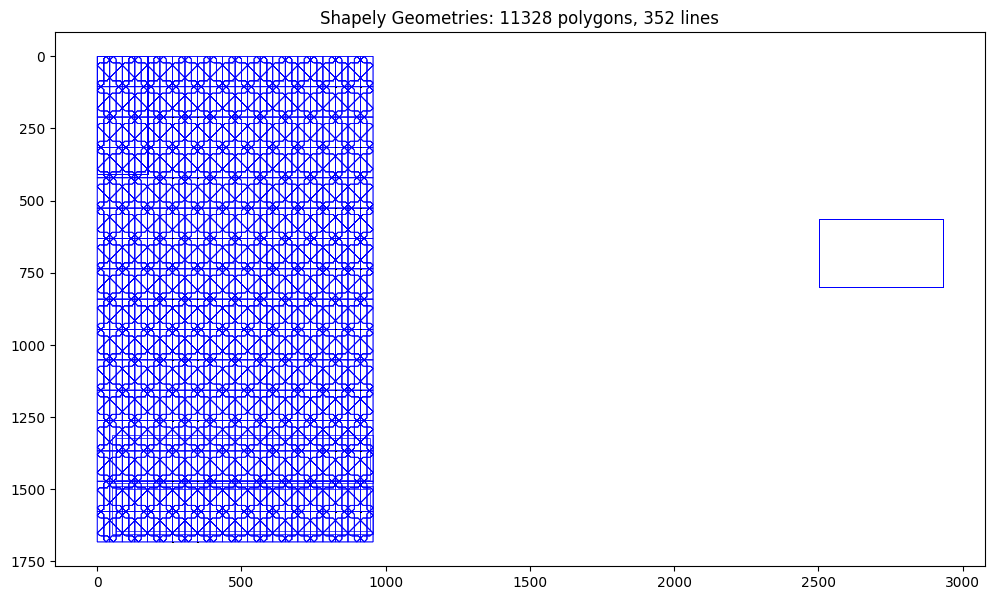

In [199]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import LineCollection


fig, ax = plt.subplots(figsize=(12, 8))

# Plot polygons
for geom in shapely_geometries:
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        polygon = MPLPolygon(coords, fill=False, edgecolor='blue', linewidth=0.5)
        ax.add_patch(polygon)
    elif isinstance(geom, LineString):
        coords = list(geom.coords)
        ax.plot([p[0] for p in coords], [p[1] for p in coords], 'k-', linewidth=0.5)

for frame in [all_frames]:
    for geom in frame:
        coords = list(geom.exterior.coords)
        polygon = MPLPolygon(coords, fill=False, edgecolor='blue', linewidth=0.5)
        ax.add_patch(polygon)

ax.set_aspect('equal')
ax.autoscale()
ax.invert_yaxis()  # SVG coordinates have Y increasing downward
plt.title(f'Shapely Geometries: {num_polygons} polygons, {num_lines} lines')
plt.show()

In [200]:
from shapely.geometry import GeometryCollection

def crop_geometries(geometries, frame):
    # Crop all geometries to the frame
    cropped_geometries = []

    for geom in shapely_geometries[:-1]:  # Exclude the frame itself (last element)
        if geom.intersects(frame):
            cropped = geom.intersection(frame)
            # intersection can return various types, so handle them
            if not cropped.is_empty:
                cropped_geometries.append(cropped)

    print(f"Cropped geometries: {len(cropped_geometries)}")

    # Count types in cropped geometries
    from shapely.geometry import MultiLineString, MultiPolygon, GeometryCollection
    num_cropped_polygons = sum(1 for g in cropped_geometries if isinstance(g, Polygon))
    num_cropped_lines = sum(1 for g in cropped_geometries if isinstance(g, LineString))
    num_multi = sum(1 for g in cropped_geometries if isinstance(g, (MultiLineString, MultiPolygon, GeometryCollection)))
    print(f"Polygons: {num_cropped_polygons}, LineStrings: {num_cropped_lines}, Multi/Collections: {num_multi}")

    return cropped_geometries

In [201]:
cropped_geometries1 = crop_geometries(shapely_geometries, iframe1)
cropped_geometries2 = crop_geometries(shapely_geometries, iframe2)

Cropped geometries: 874
Polygons: 854, LineStrings: 20, Multi/Collections: 0
Cropped geometries: 995
Polygons: 975, LineStrings: 20, Multi/Collections: 0


In [202]:
def plot_cropped_geometries(frame, cropped_geometries):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the frame
    frame_coords = list(frame.exterior.coords)
    frame_patch = MPLPolygon(frame_coords, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(frame_patch)

    # Plot cropped geometries
    for geom in cropped_geometries:
        if isinstance(geom, Polygon):
            coords = list(geom.exterior.coords)
            polygon = MPLPolygon(coords, fill=False, edgecolor='blue', linewidth=0.5)
            ax.add_patch(polygon)
        elif isinstance(geom, LineString):
            coords = list(geom.coords)
            ax.plot([p[0] for p in coords], [p[1] for p in coords], 'k-', linewidth=0.5)

    ax.set_aspect('equal')
    ax.autoscale()
    ax.invert_yaxis()
    plt.show()

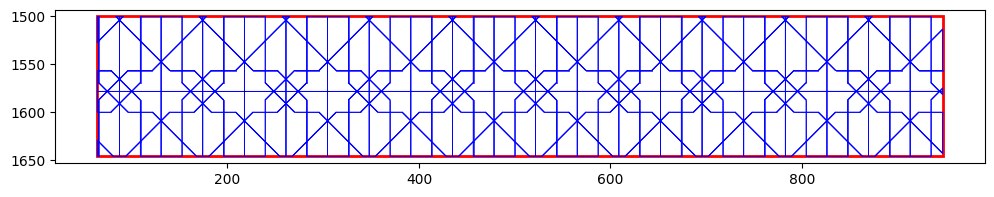

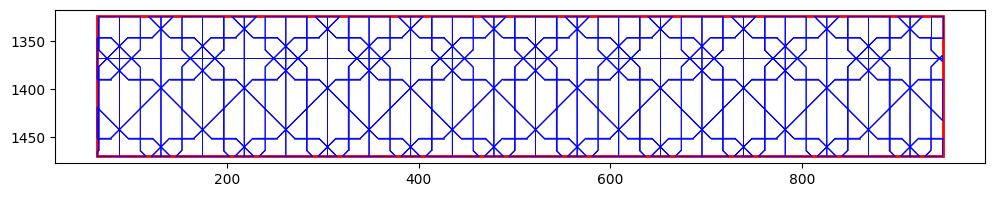

In [203]:
plot_cropped_geometries(iframe1, cropped_geometries1)
plot_cropped_geometries(iframe2, cropped_geometries2)

In [204]:
def shapely_to_svg_path(geom):
    """Convert a Shapely geometry to an SVG path string"""
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        path_parts = [f"M {coords[0][0]},{coords[0][1]}"]
        for x, y in coords[1:]:
            path_parts.append(f"L {x},{y}")
        path_parts.append("Z")
        return (" ".join(path_parts), "polygon")
    elif isinstance(geom, LineString):
        coords = list(geom.coords)
        path_parts = [f"M {coords[0][0]},{coords[0][1]}"]
        for x, y in coords[1:]:
            path_parts.append(f"L {x},{y}")
        return (" ".join(path_parts), "line")
    return ""

def save_geometries_as_svg(output_file_name, all_frames, cropped_geometries):
    """
    Save the provided geometries as SVG paths to the given file.

    Parameters:
        output_file_name (str): Path to output SVG file.
        all_frames (list): List of frame geometries (e.g., frame polygons).
        cropped_geometries (list): List of cropped geometries (Polygon and LineString).
    """
    # Use the first frame geometry for bounds
    if not all_frames:
        raise ValueError("all_frames must contain at least one geometry to compute bounds.")

    # Use the bounds of the first frame geometry for the SVG viewBox
    frame_bounds = all_frames[0].bounds  # (minx, miny, maxx, maxy)
    width = frame_bounds[2] - frame_bounds[0] + 20
    height = frame_bounds[3] - frame_bounds[1] + 20

    with open(output_file_name, 'w') as f:
        f.write(f'<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(f'<svg xmlns="http://www.w3.org/2000/svg" ')
        f.write(f'viewBox="{frame_bounds[0]-10} {frame_bounds[1]-10} {width} {height}">\n')
        
        # Write all cropped geometries and frames as paths
        for geom in cropped_geometries + all_frames:
            path_d, type = shapely_to_svg_path(geom)
            if path_d and type == "polygon":
                f.write(f'  <path d="{path_d}" fill="none" stroke="gray" stroke-width="0.5"/>\n')
            elif path_d and type == "line":
                f.write(f'  <path d="{path_d}" fill="none" stroke="#999999" stroke-width="3" stroke-linecap="round"/>\n')
        
        f.write('</svg>\n')

    print(f"Saved to {output_file_name}")

In [205]:
save_geometries_as_svg('cropped_geometries1.svg', frames1, cropped_geometries1)
save_geometries_as_svg('cropped_geometries2.svg', frames2, cropped_geometries2)

Saved to cropped_geometries1.svg
Saved to cropped_geometries2.svg
